In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def make_env(depth, cost, ground_truth):
    reward = Categorical([-1, 1])
    env = MouselabEnv(2, depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth=3, cost=.1, seed=0, n=100, ground_truth=False):
    np.random.seed(seed)
    if ground_truth:
        return [make_env(depth, cost, True) for _ in range(n)]
    else:
        return [make_env(depth, cost, False)] * n

In [10]:
agent = Agent()
def run_env(policy, env):
    agent.register(policy)
    agent.register(env)
    tr = agent.run_episode()
    return {'util': tr['return'],
            'observations': len(tr['actions']) - 1}

def evaluate(policy, envs):
    return pd.DataFrame(run_env(policy, env) for env in envs)

In [11]:
import time
def timed(method):

    def dec(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print('%r %2.2f sec' % (method.__name__, te-ts))
        return result

    return dec

In [12]:
from policies import MouselabPolicy
from skopt import gp_minimize
bounds = [ (-100., 100.) ] * 5

@timed
def bo_policy(envs, n_calls=60, verbose=False):
    def objective(theta):
        theta = np.array(theta)
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        if verbose:
            print(theta.round(3), util)
        # regularize = 0.01 * (theta ** 2).sum()
        regularize = 0
        return - (util - regularize)
    
    result = gp_minimize(objective, bounds, n_calls=n_calls, random_state=0)
    return MouselabPolicy(result.x)

In [13]:
from exact import solve
from policies import FunctionPolicy
@timed
def optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state='sort_tree')
    policy = FunctionPolicy(pi)
    return policy, V(env.init)

In [62]:

df2 = evaluate(myopic_policy, make_envs(n=500))

In [65]:
df2['agent'] = 'myopic'


In [70]:
def data():
    def dfs():
        for cost in np.logspace(-7, 0, 8, base=2):
            print('cost', cost)
            train_envs = make_envs(cost=cost, n=500)
            term = train_envs[0].term_action
            # opt_policy, opt_util = optimal_policy(train_envs[0])
            policies = {
                # 'BO': bo_policy(train_envs),
                'myopic': MouselabPolicy([1, 1, 0, 0, 1]),
                # 'optimal': opt_policy,
                # 'full': FixedPlanPolicy(range(1, term+1)),
                # 'none': FixedPlanPolicy([term]),
                # 'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
                # 'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
            }
            eval_envs = make_envs(cost=cost, n=500)
            for name, policy in policies.items():
                df = evaluate(policy, envs=eval_envs)
                df['agent'] = name
                df['cost'] = cost
                # print('======= {} ======='.format(name))
                # print('Observations: {:.3f}'.format(df.observations.mean() - 2))
                # print('Return: {:.3f}'.format(df.util.mean() / sigma))
                yield df
            # yield pd.DataFrame([{'cost': cost, 'agent': 'exact_optimal', 'util': opt_util}])
    return pd.concat(dfs())

df2 = data()
# sns.factorplot('cost', 'util', hue='agent', data=df)

cost 0.0078125
cost 0.015625
cost 0.03125
cost 0.0625
cost 0.125
cost 0.25
cost 0.5
cost 1.0


(-2, 2)

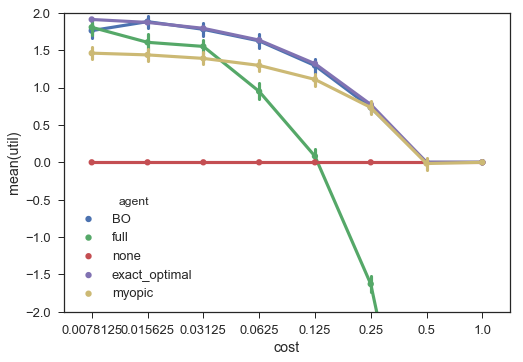

In [72]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df3, markers='.', size=(4,4), )
plt.ylim(-2, 2)

agent
BO         1.3575
full       1.4000
none       1.0000
optimal    1.5725
Name: util, dtype: float64


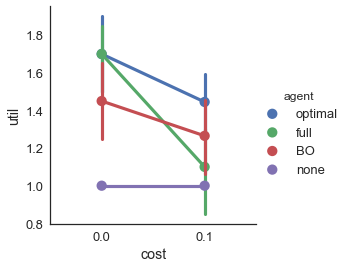

In [45]:

#                order=['none', 'one', 'two', 'full', 'BO', 'optimal'], 
              )
print(df.groupby('agent').util.mean())

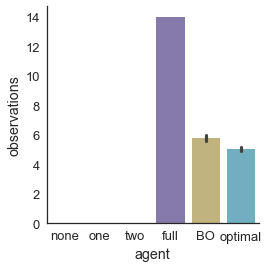

In [23]:
sns.factorplot('agent', 'observations', data=df, 
               order=['none', 'one', 'two', 'full', 'BO', 'optimal'], 
               kind='bar')

In [176]:
df.groupby('agent').observations.max()

agent
BO         6
full       6
none       0
optimal    2
Name: observations, dtype: int64

In [174]:
env.reset()
env.step(2)
env.step(4)
print(env._state)
print(Q(env._state, 1))
print(Q(env._state, 7))
pi(env._state)

(0, Cat, 1, Cat, 1, Cat, Cat)
1.5999999999999999
1.0


1